# Simulation and fitting of sources

- Simulate a source with CTA IRFs
- Can we detect "features" in the source (spectral cutoff, extension, etc) 

In [24]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

# %matplotlib inline
from IPython.display import display
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import MapDataset
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    FoVBackgroundModel,
    GaussianSpatialModel,
    PointSpatialModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.estimators import FluxPointsEstimator, ExcessMapEstimator

In [2]:
# Loading IRFs
irfs = load_irf_dict_from_file(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x14dfe5870>,
 'psf': <gammapy.irf.psf.parametric.EnergyDependentMultiGaussPSF at 0x14dfe6fb0>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x14dfe6da0>,
 'bkg': <gammapy.irf.background.Background3D at 0x14dfa94b0>}

In [3]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 2.0 * u.hr
pointing_position = SkyCoord(0, 0, unit="deg", frame="galactic")

# We want to simulate an observation pointing at a fixed position in the sky.
# For this, we use the `FixedPointingInfo` class
pointing = FixedPointingInfo(
    fixed_icrs=pointing_position.icrs,
)

In [4]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(geom, name="dataset-simu", energy_axis_true=energy_true)


In [76]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = GaussianSpatialModel(
    lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.1 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.200   +/-    0.00 deg         
    lat_0                         :      0.100   +/-    0.00 deg         
    sigma                         :      0.100   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpec

### Simulate

In [77]:
# Create an in-memory observation
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.08
	duration          : 7200.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [78]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 0 
  Total background counts         : 161250.95
  Total excess counts             : -161250.95

  Predicted counts                : 161250.95
  Predicted background counts     : 161250.95
  Predicted excess counts         : nan

  Exposure min                    : 4.08e+02 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 810000 
  Number of fit bins              : 804492 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [79]:
# Add the model on the dataset and Poisson fluctuate
dataset.models = models
dataset.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 162029 
  Total background counts         : 161250.95
  Total excess counts             : 778.05

  Predicted counts                : 162123.04
  Predicted background counts     : 161250.95
  Predicted excess counts         : 872.09

  Exposure min                    : 4.08e+02 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 810000 
  Number of fit bins              : 804492 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 560145.90

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters

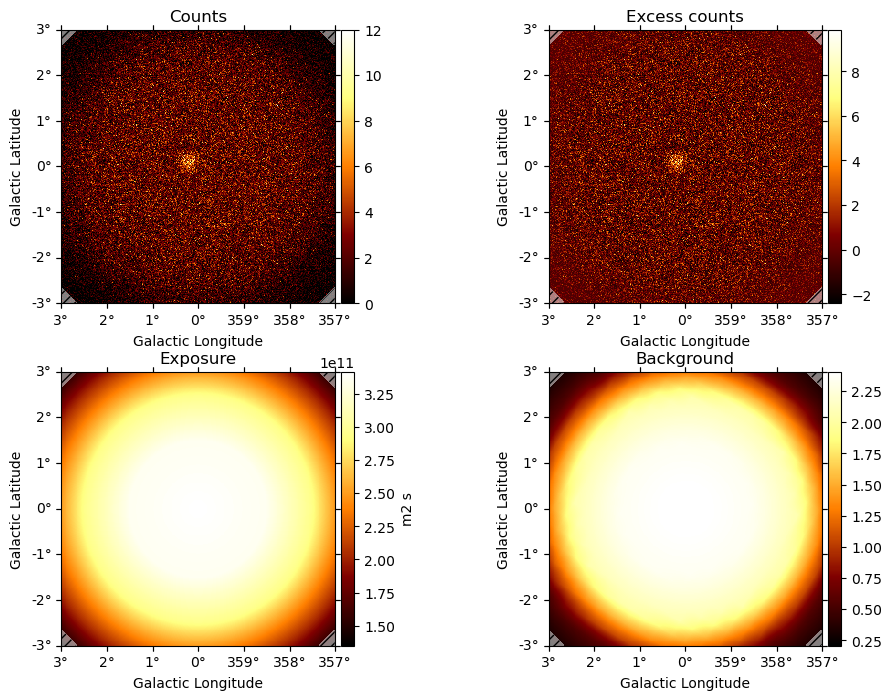

In [80]:
dataset.peek()

## Now, we will fit this dataset

H0 : No source, only background
H1 : point-like source
H2 : extended source

In [81]:
models = Models()

In [82]:

bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
models.append(bkg_model)
models

In [83]:
dataset.models = models

In [84]:
fit = Fit()
result0 = fit.run(datasets=[dataset])


In [85]:
L0 = result0.total_stat
L0

560724.4275897462

## Compute the excess map 

In [86]:
est = ExcessMapEstimator(correlation_radius='0.1 deg')

In [87]:
maps1 = est.run(dataset)

In [88]:
maps1.available_quantities

['npred', 'npred_excess', 'counts', 'ts', 'sqrt_ts', 'norm', 'norm_err']

<WCSAxes: >

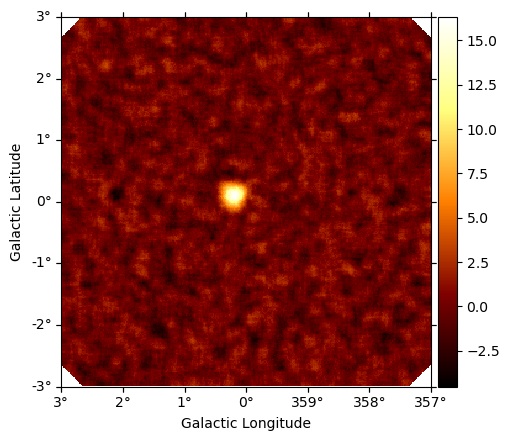

In [89]:
maps1["sqrt_ts"].plot(add_cbar=True)

There is clearly a source. Now, add a point spatial model

In [90]:
spatial1 = PointSpatialModel(frame="galactic")

In [91]:
spatial1.lon_0.value = 0.0
spatial1.lat_0.value = 0.0

In [92]:
spectral1 = PowerLawSpectralModel()
spectral1.index.value = 2.0
spectral1.amplitude.value = 1e-12

In [93]:
sky1 = SkyModel(spectral_model=spectral1, spatial_model=spatial1, name="pnt")

In [95]:
models.append(sky1)
dataset.models = models

In [96]:
result1 = fit.run(datasets=[dataset])

In [97]:
L1 = result1.total_stat
L1

560330.7256762825

In [99]:
print("Point source TS: ", L0-L1)

Point source TS:  393.70191346365027


In [100]:
dataset.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str16,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
dataset-simu-bkg,,norm,1.0020e+00,,2.497e-03,nan,nan,False,True,,
dataset-simu-bkg,,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,,
dataset-simu-bkg,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
pnt,,index,3.2765e+00,,1.274e-01,nan,nan,False,False,,
pnt,,amplitude,3.4277e-13,TeV-1 s-1 cm-2,7.198e-14,nan,nan,False,True,,
pnt,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
pnt,,lon_0,1.9906e-01,deg,4.175e-03,nan,nan,False,False,,
pnt,,lat_0,9.9395e-02,deg,4.224e-03,-9.000e+01,9.000e+01,False,False,,


In [101]:
## Convert TS to significance

from scipy.stats import chi2, norm

def sigma_to_ts(sigma, df=1):
    """Convert sigma to delta ts"""
    p_value = 2 * norm.sf(sigma)
    return chi2.isf(p_value, df=df)

def ts_to_sigma(ts, df=1):
    """Convert delta ts to sigma"""
    p_value = chi2.sf(ts, df=df)
    return norm.isf(0.5 * p_value)

## Again, compute excess maps

In [103]:
maps2 = est.run(dataset)

<WCSAxes: >

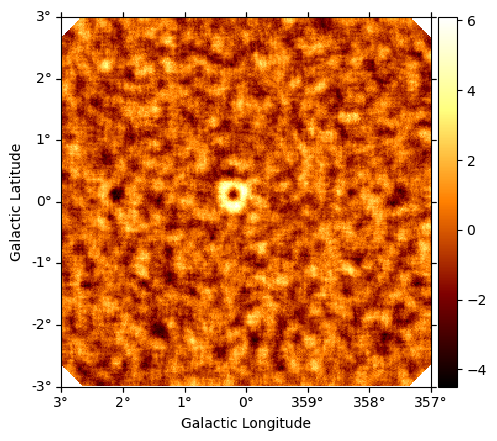

In [104]:
maps2["sqrt_ts"].plot(add_cbar=True)

The TS map looks funny!
Try fitting an extended source...